# Bike Sharing Demand
<hr style="border:2px solid black">

This notebook contains a semi-guided open-ended mini project, where the reader will recollect some of the already-introduced concepts. 

<img src="../data/capital_bikeshare.png" width="800"/>

## 1. Introduction

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### 1.1 Load Packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [66]:
# machine-learning stack
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
# cross_val_score
from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor

In [3]:
# math and stat
import scipy.stats as ss

In [4]:
# miscellaneous
import time
import joblib
import warnings
warnings.filterwarnings("ignore")

### 1.2 Data Description

We are provided hourly rental data spanning two years. The dataset covers the first 19 days of each month.

#### Data Fields

|column|description|
|:--------:|:-------------------------:|
|`datetime`| hourly date + timestamp|
|`season`|  1 = spring, 2 = summer, 3 = fall, 4 = winter| 
|`holiday`| whether the day is considered a holiday|
|`workingday`| whether the day is neither a weekend nor holiday|
|`weather`| 1: Clear, Few clouds, Partly cloudy|
||2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist|
||3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds|
||4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog|
|`temp`|temperature in Celsius|
|`atemp`| "feels like" temperature in Celsius|
|`humidity`| relative humidity|
|`windspeed`| wind speed|
|`casual`| number of non-registered user rentals initiated|
|`registered`|number of registered user rentals initiated|
|`count`|number of total rentals|

### 1.3 User Defined Functions

In [5]:
def cramers_corrected_stat(df,cat_col1,cat_col2):
    """
    This function spits out corrected Cramer's correlation statistic
    between two categorical columns of a dataframe 
    """
    crosstab = pd.crosstab(df[cat_col1],df[cat_col2])
    chi_sqr = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r,k = crosstab.shape
    phi_sqr_corr = max(0, chi_sqr/n - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi_sqr_corr / min( (k_corr-1), (r_corr-1)))
    return round(result,3)

In [6]:
def anova_pvalue(df,cat_col,num_col):
    """
    This function spits out the anova p-value (probability of no correlation) 
    between a categorical column and a numerical column of a dataframe
    """
    CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
    AnovaResults = ss.f_oneway(*CategoryGroupLists)
    p_value = round(AnovaResults[1],3)
    return p_value

## 2. Get Data

In [7]:
# read training data from file
df = pd.read_csv('../data/bike_sharing_data.csv', parse_dates=[0])

### Data Quick Check

In [8]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,13
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,32
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,27
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,10
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10881 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [10]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

In [11]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          5
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

Observation: Apparently, missing values appear only in temperature column. But some missing values could be in disguise of zero.

### Train-Test Split

In [12]:
train,test = train_test_split(df,test_size=0.2,random_state=42)
train.shape, test.shape

((8708, 10), (2178, 10))

## 3. Exploratory Data Analysis

### 3.1 Target Properties

In [13]:
# target
target = 'count'

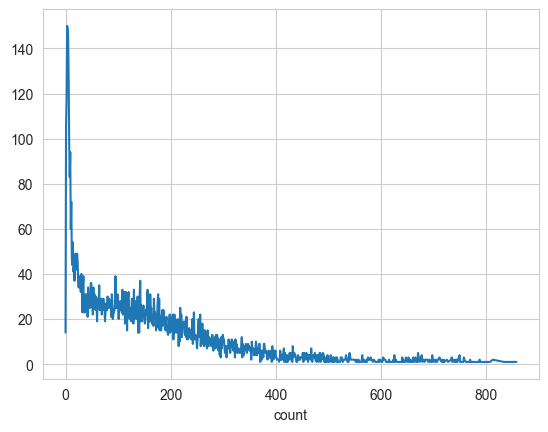

In [14]:
target_dist= train[target].value_counts()
sns.lineplot(
    x=target_dist.index,
    y=target_dist.values
);

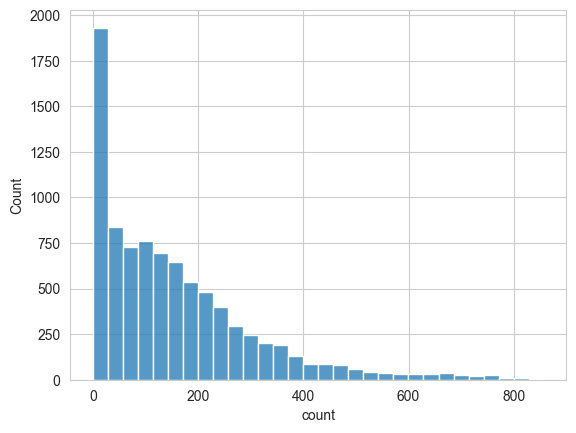

In [15]:
sns.histplot(train[target], bins=30);

- Observation: Count data is skewed

### 3.2 Categorical Features

#### Create new relevant temporal fetures

In [42]:
# create 'year', 'month', 'weekday','hour' columns from 'datetime'
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['weekday'] = train['datetime'].dt.weekday
train['hour'] = train['datetime'].dt.hour
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,weekday,hour,log_count,day_type
2815,2011-07-06 05:00:00,3,0,1,1,27.88,31.820,83,6.0032,30,2011,7,2,5,3.433987,0
8695,2012-08-04 16:00:00,3,0,0,1,36.90,40.910,39,19.9995,253,2012,8,5,16,5.537334,1
8406,2012-07-11 15:00:00,3,0,1,1,32.80,35.605,41,16.9979,220,2012,7,2,15,5.398163,0
1543,2011-04-10 04:00:00,2,0,0,2,14.76,18.180,93,7.0015,2,2011,4,6,4,1.098612,1
4952,2011-11-19 10:00:00,4,0,0,1,13.12,15.150,45,16.9979,165,2011,11,5,10,5.111988,1


#### count vs year

0.0

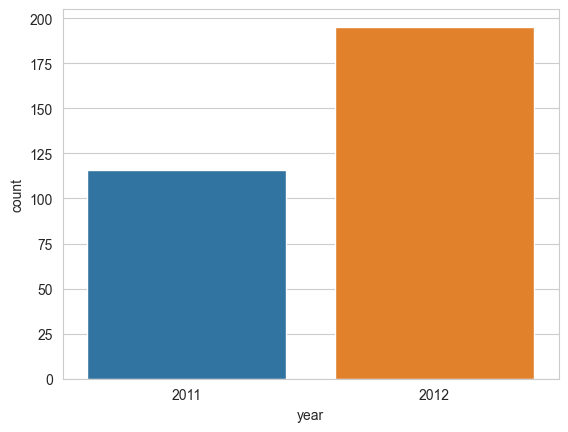

In [17]:
df_year = train.groupby('year')['count'].mean().reset_index()
sns.barplot(data=df_year,x='year',y='count');
anova_pvalue(train,'year','count')

#### count vs season

0.0

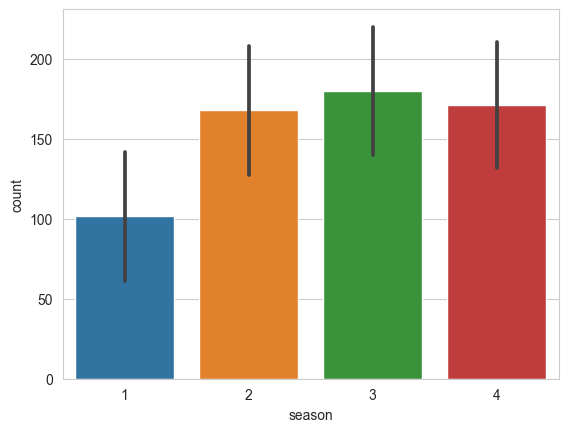

In [18]:
df_season = train.groupby(['year','season'])['count'].mean().reset_index()
sns.barplot(data=df_season,x='season',y='count');
anova_pvalue(train,'season','count')

In [43]:
df_season

,year,season,count
0,2011,1,61.175689
1,2011,2,127.712080
2,2011,3,139.678245
3,2011,4,132.015568
4,2012,1,141.935603
5,2012,2,208.061299
6,2012,3,220.218664
7,2012,4,210.480365


#### count vs month

0.0

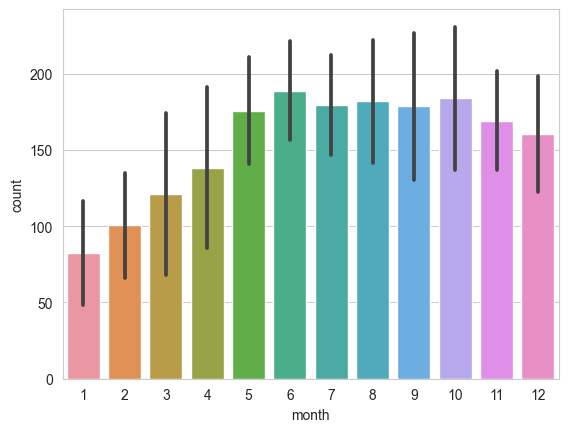

In [19]:
df_month = train.groupby(['year','month'])['count'].mean().reset_index()
sns.barplot(data=df_month,x='month',y='count');
anova_pvalue(train,'month','count')

#### count vs hour

0.0

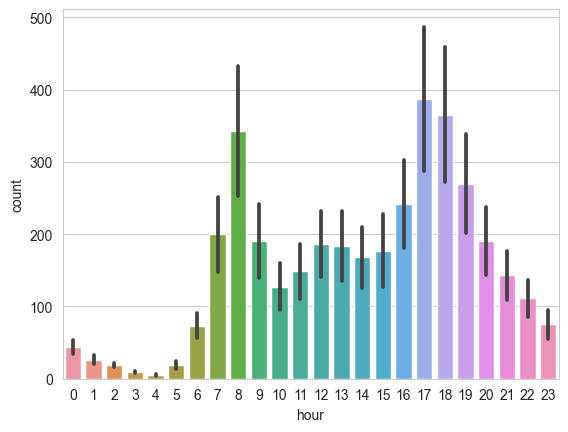

In [20]:
df_hour = train.groupby(['year','hour'])['count'].mean().reset_index()
sns.barplot(data=df_hour,x='hour',y='count');
anova_pvalue(train,'hour','count')

#### count vs weekday

0.0

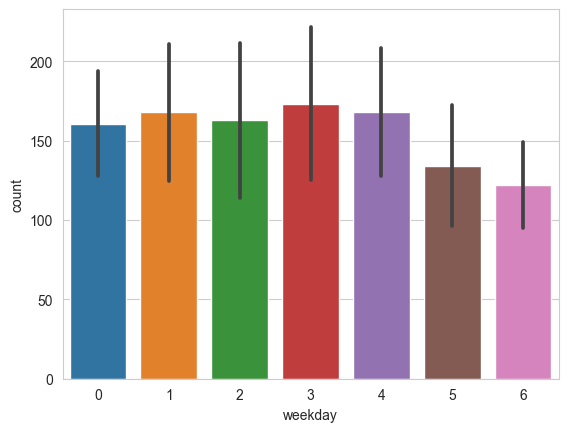

In [21]:
df_weekday = train.groupby(['year','weekday'])['count'].mean().reset_index()
sns.barplot(data=df_weekday,x='weekday',y='count');
anova_pvalue(train,'weekday','count')

#### count vs workingday

0.0

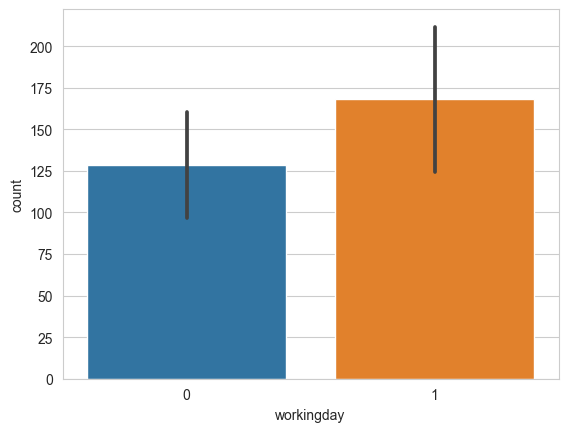

In [22]:
df_work = train.groupby(['year','workingday'])['count'].mean().reset_index()
sns.barplot(data=df_work,x='workingday',y='count');
anova_pvalue(train,'workingday','count')

#### count vs holiday

0.024

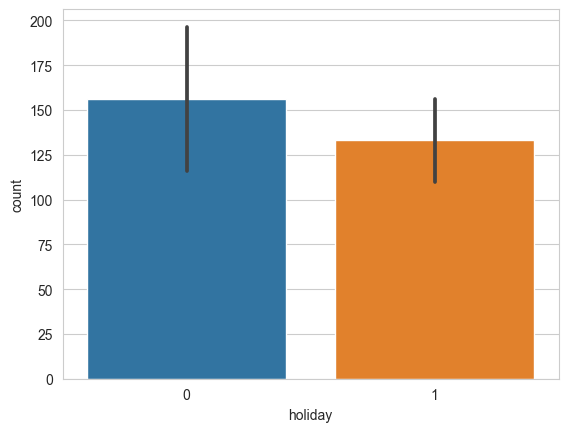

In [23]:
df_holiday = train.groupby(['year','holiday'])['count'].mean().reset_index()
sns.barplot(data=df_holiday,x='holiday',y='count');
anova_pvalue(train,'holiday','count')

#### count vs weather

0.0

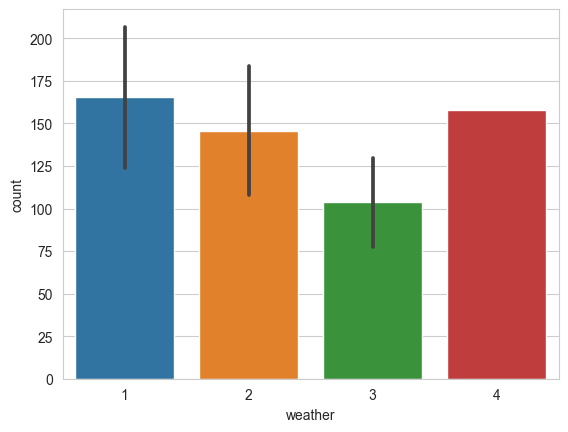

In [24]:
df_weather = train.groupby(['year','weather'])['count'].mean().reset_index()
sns.barplot(data=df_weather,x='weather',y='count');
anova_pvalue(train,'weather','count')

#### Correlation among features (Cramer's V)

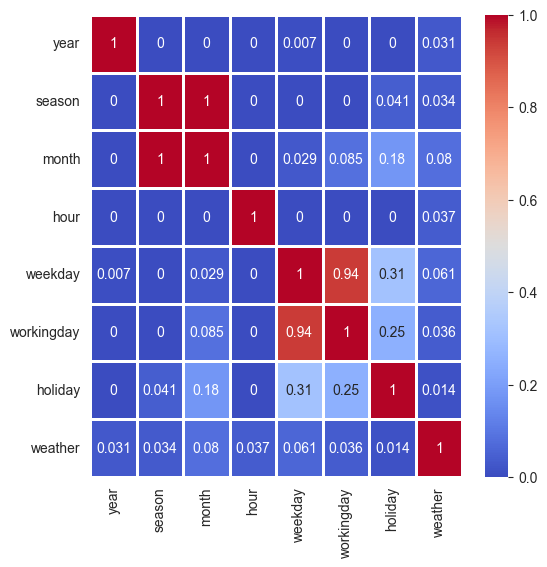

In [25]:
cat_feat = ['year','season','month','hour','weekday','workingday','holiday','weather']
cramer_v_corr = {}
for feat1 in cat_feat:
    cramer_v_corr[feat1] = [cramers_corrected_stat(train,feat1,feat2) for feat2 in cat_feat]
cat_corr = pd.DataFrame(index=cramer_v_corr.keys(),data=cramer_v_corr)

plt.figure(figsize=(6,6),dpi=100)
sns.heatmap(data=cat_corr, cmap='coolwarm', linecolor='white', linewidth=1, annot=True);

### 3.3 Numerical Features

#### temperature vs count

correlation value: 0.312


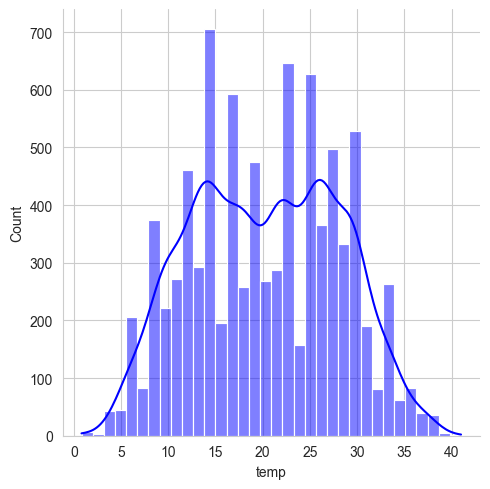

In [26]:
sns.displot(train['temp'], kde=True, color='blue');
corr_ = round(train['temp'].corr(train['count']),3)
print(f'correlation value: {corr_}')

#### feels-like temperature vs count

correlation value: 0.309


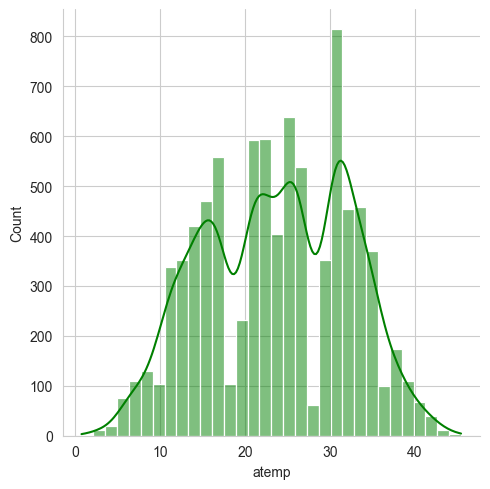

In [27]:
sns.displot(train['atemp'], kde=True, color='green');
corr_ = round(train['atemp'].corr(train['count']),3)
print(f'correlation value: {corr_}')

#### count vs humidity

correlation value: -0.265


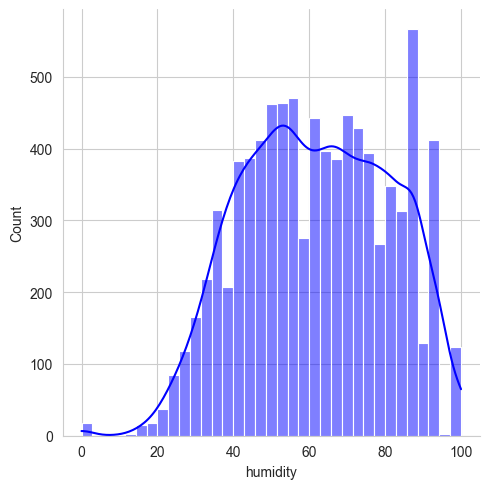

In [28]:
sns.displot(train['humidity'], kde=True, color='blue');
corr_ = round(train['humidity'].corr(train['count']),3)
print(f'correlation value: {corr_}')

correlation value: 0.088


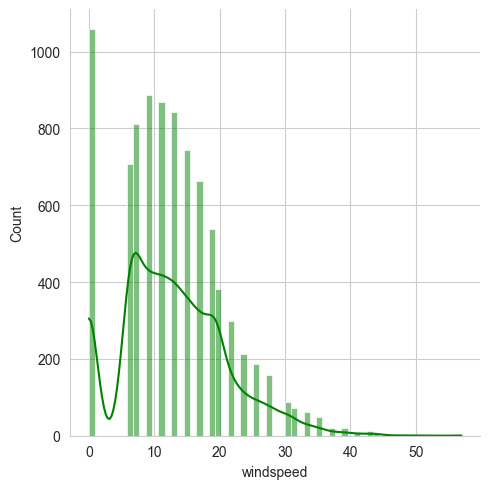

In [29]:
sns.displot(train['windspeed'], kde=True, color='green');
corr_ = round(train['windspeed'].corr(train['count']),3)
print(f'correlation value: {corr_}')

Observation: Windspeed not well distributed; Missing values reported as 0; imputation needed

#### cross correlation of features

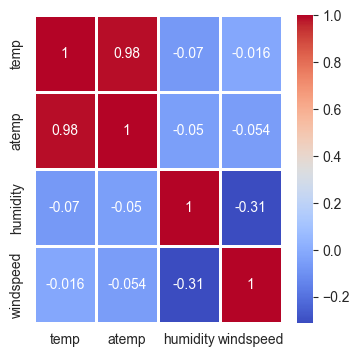

In [30]:
num_feat = ['temp', 'atemp','humidity','windspeed']
plt.figure(figsize=(4,4),dpi=100)
sns.heatmap(data=train[num_feat].corr(), cmap='coolwarm', linecolor='white', linewidth=1, annot=True);

## 4. Feature Engineering

#### Target variables

Because the target variable is skewed, one can make a logarithmic transformation to render it more amenable to ML models that generically perform better for unskewed target variable distribution.

In [31]:
train['log_count'] = np.log1p(train['count'])

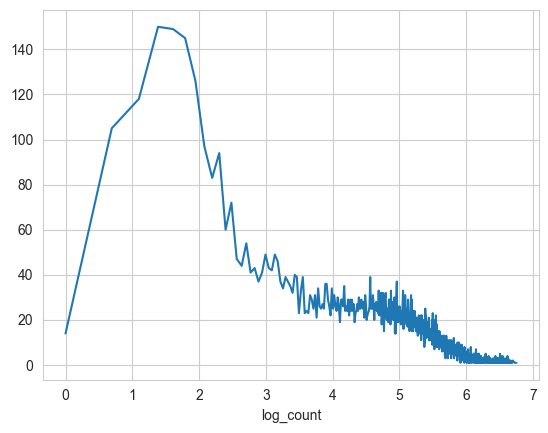

In [32]:
target_dist= train['log_count'].value_counts()
sns.lineplot(
    x=target_dist.index,
    y=target_dist.values
);

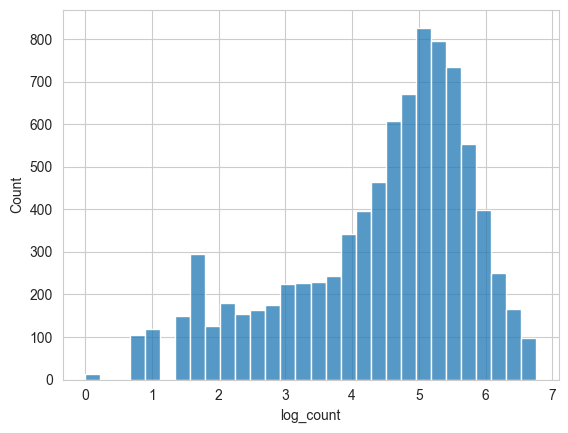

In [33]:
sns.histplot(train['log_count'], bins=30);

#### New column: 'day_type'

In [34]:
# weekends are non-working days that are not holidays either
# workingdays and holidays do not overlap
train.groupby(['workingday','holiday','weekday'])[['count']].count()

count
workingday holiday weekday       
0          0       5         1265
                   6         1259
           1       0          192
                   2           19
                   4           43
1          0       0         1032
                   1         1235
                   2         1218
                   3         1250
                   4         1195

Comment: create new categorical column with three categories: workingday, holiday and weekend 

In [35]:
# new column 'day_type'
train['day_type'] = train.apply(
    lambda x: 0 if x['workingday']==1 else 1 if x['holiday']==0 else 2,
    axis=1
)

0.0

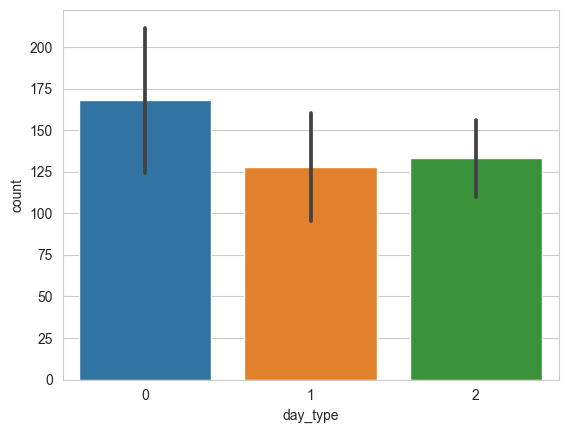

In [36]:
# count vs day type
df_day = train.groupby(['year','day_type'])['count'].mean().reset_index()
sns.barplot(data=df_day,x='day_type',y='count');
anova_pvalue(train,'day_type','count')

#### Imputation: temperature

In [37]:
temp_imputer = SimpleImputer(strategy='mean')

In [38]:
temp_imputer.fit(train[['temp']])

SimpleImputer()

In [40]:
train['temp'] = temp_imputer.transform(train[['temp']])

#### Imputation: windspeed

In [41]:
# impute zero values of windspeed as missing values

In [44]:
train['windspeed'].replace(0, np.nan, inplace=True)

In [47]:
#Impute NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
train['windspeed'] = imputer.fit_transform(train[['windspeed']])

## 5. Model Building

### 5.1 Feature Selection

In [113]:
#feature-target separation
target = 'count'

# feature column names
features = list(set(train.columns) - set([target]))

# Splitting the DataFrame into Features and Target:
X_train, y_train = train[features], train[target]
X_train.shape, y_train.shape

#cat_features = list(X_train.select_dtypes(include=['datetime']).columns)
num_features = list(X_train.select_dtypes(exclude=['object']).columns)
# Convert the 'datetime' column to float (timestamp)
X_train['datetime'] = X_train['datetime'].apply(lambda x: x.timestamp())

#pre-processing pipelines
num_transformer = Pipeline(
    steps=[
         ('imputer_num', SimpleImputer(strategy='mean')),  # imputer_numerical we just give a name for later steps
         ('scaling_num', StandardScaler()),       # scaling_num  we just give a name for later steps
         ('poly_num', PolynomialFeatures(degree=2)) 
    ])


# Syntax: Requires specifying steps as a list of tuples, where each tuple contains a name and a transformation.
# demands Pipeline
cat_transformer = Pipeline(
    steps=[
        # Step 1: Impute missing values in the categorical data
        # Use SimpleImputer with strategy='most_frequent' to fill missing values
        # with the most frequent (mode) value in the column.
        ('imputer_cat', SimpleImputer(strategy='most_frequent')),
        
        # Step 2: Apply one-hot encoding to the categorical data
        # Use OneHotEncoder to convert categorical values into binary columns.
        # 'drop='first'' drops the first category to avoid multicollinearity (dummy variable trap).
        # 'handle_unknown='ignore'' ensures that any unknown categories encountered during transformation
        # are ignored rather than raising an error.
        ('onehot_cat', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
 
# total processing    
preprocessor = ColumnTransformer(
    transformers=[
        ('transformer_num', num_transformer, num_features), # what is pipeline for num_features list defined by num_transformer
        ('transformer_cat', cat_transformer, cat_features)  # what is pipeline for cat_features list defined by cat_transformer
    ])
# 'transformer_num': A name for the transformer, for later operations.
# num_transformer: The actual pipeline or sequence of preprocessing steps for numerical features.
# num_features: A list or array of column names (or indices) that this transformer will be applied to. 


### 5.2 Train Model

In [114]:
#instantiate model
linear_model = Pipeline(
    steps=[
        ('preprocessor_name', preprocessor),
        ('regressor', LinearRegression())
    ])

linear_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor_name',
                 ColumnTransformer(transformers=[('transformer_num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaling_num',
                                                                   StandardScaler()),
                                                                  ('poly_num',
                                                                   PolynomialFeatures())]),
                                                  ['hour', 'month', 'atemp',
                                                   'workingday', 'windspeed',
                                                   'year', 'weekday',
                                                   'day_type', 'weather',
                                                   'season', 'holiday', 'temp',
                                                   'humidity', 'log_count',
                                                   'datetime']),
                                                 ('transformer_cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['datetime'])])),
                ('regressor', LinearRegression())])

### 5.3 Model Validation

In [115]:
training_score = linear_model.score(X_train,y_train)
print(f"training r2 score: {round(training_score, 6)}")

training r2 score: 0.999999


## 6. Model Evaluation

In [130]:
# feature - target separation
#X_test, y_test = test[features], test[target]
X_test, y_test = test.drop('count', axis=1), test[target]

# model performace
test_score = linear_model.score(X_test,y_test)
print(f"test r2 score: {round(test_score, 6)}")

KeyError: "['hour', 'month', 'year', 'weekday', 'day_type', 'log_count'] not in index"